In [1]:
# imports off all the "utils" used
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import itertools
from geopy.distance import geodesic
import copy
from pprint import pprint

# import of Annealer class. It internally handles temperatures, state and other simulated annealing
# paramteres allowing us to concentrate on defining proper energy/step calculation.
from simanneal import Annealer

In [2]:
# Input data
cities = [
    { "name": "Białystok", "coor": (53.134134732753864, 23.153310966400596), "price": 500},
    { "name": "Bielsko-Biała", "coor": (49.81876161968031, 19.04617968034641), "price": 50},
    { "name": "Chrzanów", "coor": (50.12913692651441, 19.395768504838273), "price":400},
    { "name": "Gdańsk", "coor": (54.36796400827984, 18.63369059882357), "price":200},
    { "name": "Gdynia", "coor": (54.53841612193148, 18.497803301437234), "price":100},
    { "name": "Gliwice", "coor": (50.29369876426428, 18.671580138935177), "price":40},
    { "name": "Gromnik", "coor": (49.837971066992765, 20.96166976957584), "price":200},
    { "name": "Katowice", "coor": (50.24916658473379, 19.01817014484935), "price":300},
    { "name": "Kielce", "coor": (50.865658615754896, 20.633485374827472), "price":30},
    { "name": "Krosno", "coor": (49.684747125453015, 21.760344405407906), "price":60},
    { "name": "Krynica", "coor": (49.42838490105043, 20.944014133262424), "price":50},
    { "name": "Lublin", "coor": (51.24425317478849, 22.556208415607344), "price":60},
    { "name": "Łódź", "coor": (51.77345953700654, 19.485390493733036), "price":160},
    { "name": "Malbork", "coor": (54.03690023757196, 19.03865228204472), "price":100},
    { "name": "Nowy Targ", "coor": (49.48367055790955, 20.03757836902064), "price":120},
    { "name": "Olsztyn", "coor": (53.776740593715616, 20.47324372998899), "price":300},
    { "name": "Poznań", "coor": (52.40522451042169, 16.926351809287887), "price":100},
    { "name": "Puławy", "coor": (51.42293058773698, 21.964022516794977), "price":200},
    { "name": "Radom", "coor": (51.39527860506102, 21.15671183618801,), "price":100},
    { "name": "Rzeszów", "coor": (50.030935266290385, 22.006985454028776), "price":60},
    { "name": "Sandomierz", "coor": (50.686578016612785, 21.74045959404254), "price":200},
    { "name": "Szczecin", "coor": (53.433459365009334, 14.598498659089259), "price":150},
    { "name": "Szczucin", "coor": (50.31335624967705, 21.076353145156556), "price":60},
    { "name": "Szklarska Poręba", "coor": (50.83284343262097, 15.474106835458459), "price":50},
    { "name": "Tarnów", "coor": (50.00973493308794, 20.967970790632194), "price":70},
    { "name": "Warszawa", "coor": (52.253628343762465, 21.025455121546234), "price":200},
    { "name": "Wieliczka", "coor": (49.984667202642605, 20.058810392223194), "price":90},
    { "name": "Wrocław", "coor": (51.119847633185245, 17.022041970659068), "price":40},
    { "name": "Zakopane", "coor": (49.29154692809875, 19.96666364076246), "price":200 },
    { "name": "Zamość", "coor": (50.72114416519538, 23.261213327460545), "price":300 }
]

start_coors = {"name": "Kraków", "coor": (50.07243688729374, 19.95266052647055)}

max_car_capacity = 1000
cars = 5

In [3]:
# We randomize the user's input
randomized_cities = copy.deepcopy(cities)
random.shuffle(randomized_cities)

In [4]:
# This function is used for initial division of targets between all the cars
def pick_routes_for_cars(cities):
    temp_cities = copy.deepcopy(cities)
    cars_routes = [[] for _ in range(cars)]
    for i in range(cars):
        curret_car_cap = max_car_capacity
        for j in range (len(temp_cities)):
            curret_city_price = temp_cities[j]["price"]
            if curret_car_cap - curret_city_price >= 0:
                cars_routes[i].append(cities[j])
                curret_car_cap -= curret_city_price
                temp_cities[j]["price"] = max_car_capacity + 1
    return cars_routes     


# This function swaps two cities between two cars
def switch_cities_for_car(state):
    a = random.randint(0, len(state) - 1)
    b = (a + 1)%(len(state))
    state[a], state[b] = state[b], state[a]
    

# Sum capacity need to visit all the cities for a car
def sum_car_price(car):
    price = 0
    for i in range(len(car)):
        price+=car[i]["price"]
    return price


# Get distance the car has to travel to visit all the cities that are assigned to it
def car_distance(car):
    curr_dist = 0
    for j in range(len(car)):
        if j == 0:
            curr_dist+=geodesic(start_coors["coor"], car[j]["coor"]).km
        else:
            curr_dist+=geodesic(car[j]["coor"], car[j-1]["coor"]).km
    return curr_dist

# Check if city swap is possbile between two cars
def get_index_if_possible(city_to_swap, origin_car, to_car):
    price_origin_car = sum_car_price(origin_car)
    price_to_car = sum_car_price(to_car)
    
    
    to_take = city_to_swap["price"] + max_car_capacity - price_origin_car
    
    
    min_val = price_to_car + city_to_swap["price"] - max_car_capacity
    
    for i in range(len(to_car)):
        if min_val <= to_car[i]["price"] <= to_take:
            return i
    return -1

In [5]:
# Simulated annealing implementation of the problem that in each step swaps two cities
# that a car is assigned to
class TransportOptimization(Annealer):
    def __init__(self, state):
        self.Ts=[]
        self.Es=[]
        super(TransportOptimization, self).__init__(state)  # important!
        
    def move(self):        
        for i in range(len(self.state)):
            switch_cities_for_car(self.state[i])
        
    def energy(self):
        e = 0
        for i in range(len(self.state)):
            curr_dist = 0
            for j in range(len(self.state[i])):
                if j == 0:
                    curr_dist+=geodesic(start_coors["coor"], self.state[i][j]["coor"]).km
                else:
                    curr_dist+=geodesic(self.state[i][j]["coor"], self.state[i][j-1]["coor"]).km
            e+=curr_dist
        return e
    def update(self, step, T, E, acceptance, improvement):
        self.Ts.append(T)
        self.Es.append(E)
    def getData(self):
        return self.Es, self.Ts


# Simulated annealing implementation which swap two random cities between two random cars and
# also swaps two random cities assigned to each car
class TransportOptimizationWithSwaps(Annealer):
    def __init__(self, state):
        self.Ts=[]
        self.Es=[]
        super(TransportOptimizationWithSwaps, self).__init__(state)  # important!
        
    def move(self):
        car_to_change = random.randint(0, len(self.state) - 1)
        city_to_change = random.randint(0, len(self.state[car_to_change]) - 1)
        
        for i in range(len(self.state)):
            if i == car_to_change:
                continue
            else:
                index = get_index_if_possible(self.state[car_to_change][city_to_change], self.state[car_to_change], self.state[i])
                if index > -1:
                    self.state[car_to_change][city_to_change], self.state[i][index] = self.state[i][index], self.state[car_to_change][city_to_change]
        for i in range(len(self.state)):
            switch_cities_for_car(self.state[i])

    
    def energy(self):
        e = 0
        for i in range(len(self.state)):
            curr_dist = 0
            for j in range(len(self.state[i])):
                if j == 0:
                    curr_dist+=geodesic(start_coors["coor"], self.state[i][j]["coor"]).km
                else:
                    curr_dist+=geodesic(self.state[i][j]["coor"], self.state[i][j-1]["coor"]).km
            e+=curr_dist
        return e
    def update(self, step, T, E, acceptance, improvement):
        self.Ts.append(T)
        self.Es.append(E)
    def getData(self):
        return self.Es, self.Ts



Distance:  4893.112366547192


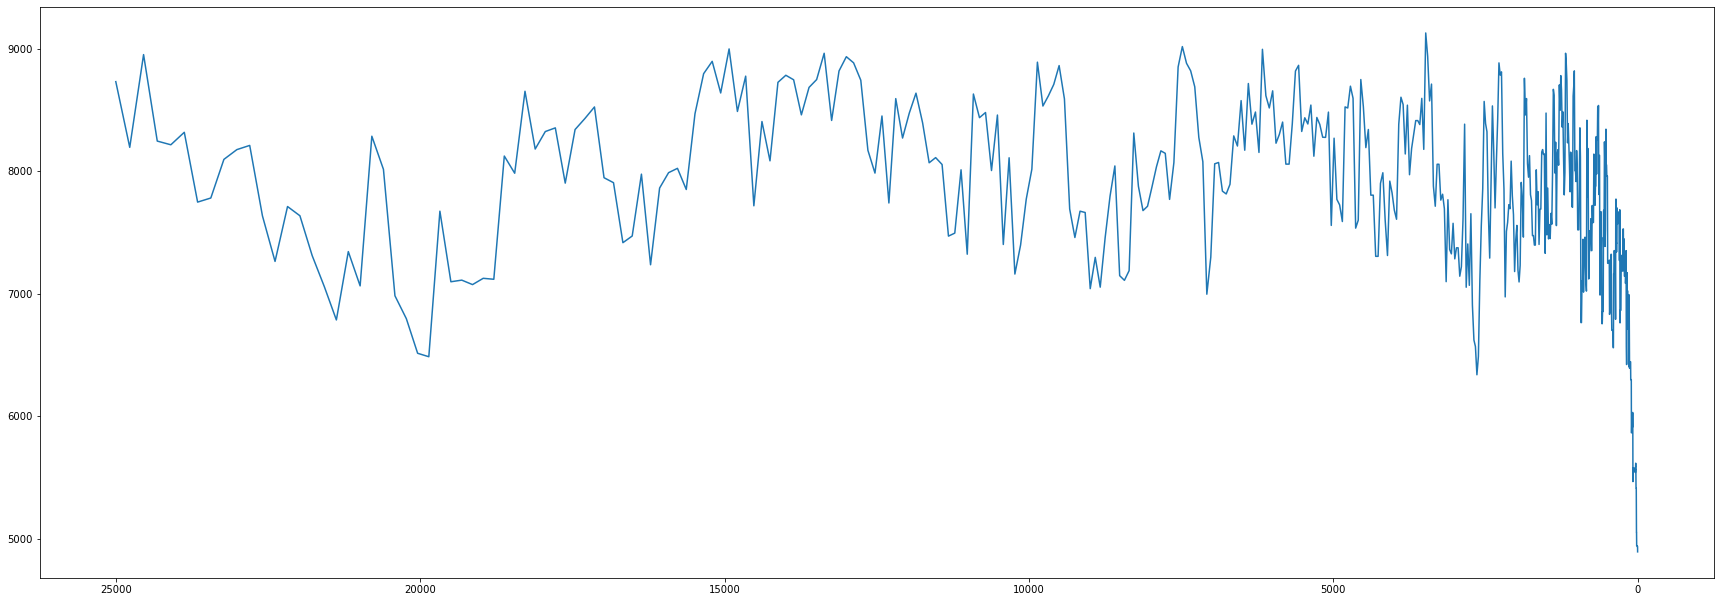

In [6]:
# Run of the first version of the implementation
tsp = TransportOptimization(pick_routes_for_cars(randomized_cities))
tsp.updates = 1000
tsp.steps= 1000
a, b = tsp.anneal()

print("Distance: ", b)
E, T = tsp.getData()
plt.plot(T, E)
ax = plt.gca()
ax.invert_xaxis()
plt.gcf().set_size_inches(30, 10.5)
plt.show()

Distance:  4489.3541663881315


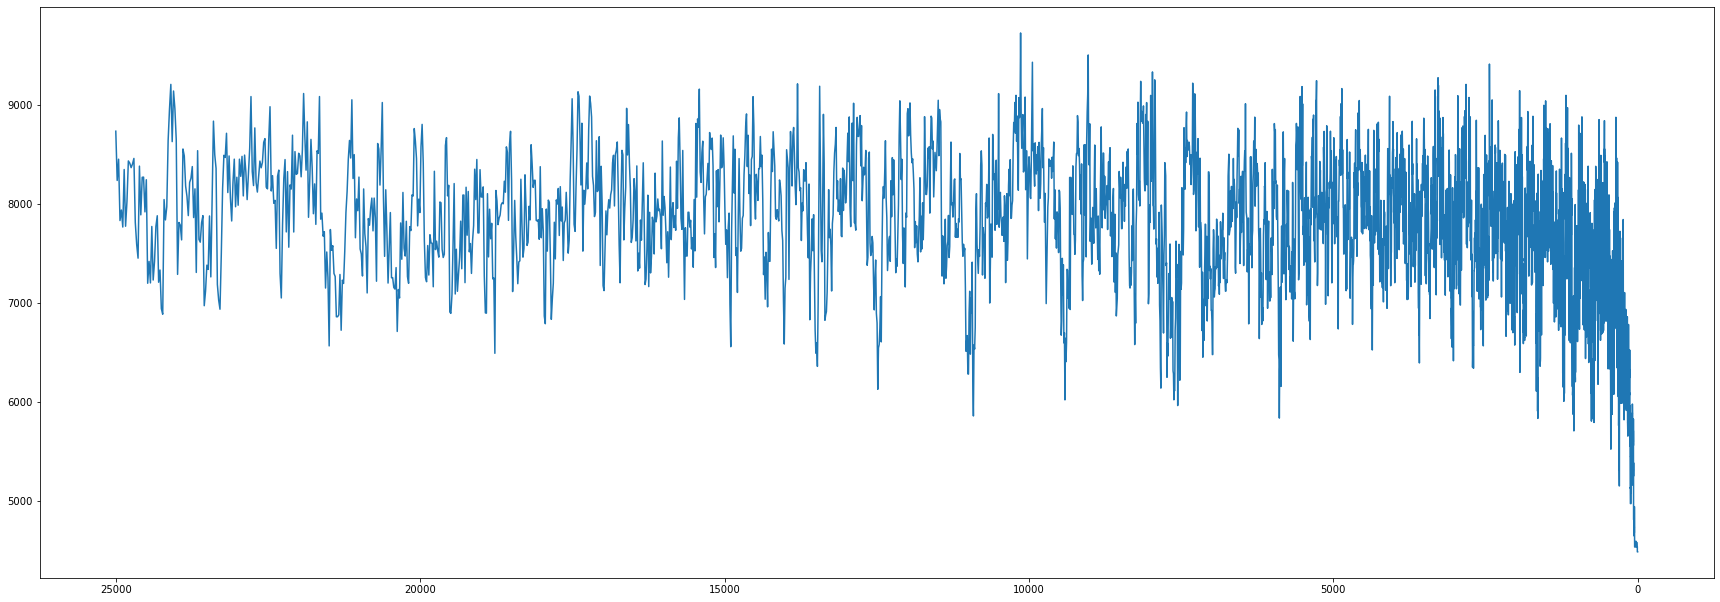

In [7]:
# Run of the first version of the implementation
tsp = TransportOptimization(pick_routes_for_cars(randomized_cities))
tsp.updates = 10000
tsp.steps= 10000
a, b = tsp.anneal()

print("Distance: ", b)
E, T = tsp.getData()
plt.plot(T, E)
ax = plt.gca()
ax.invert_xaxis()
plt.gcf().set_size_inches(30, 10.5)
plt.show()

Distance:  4909.280245087267


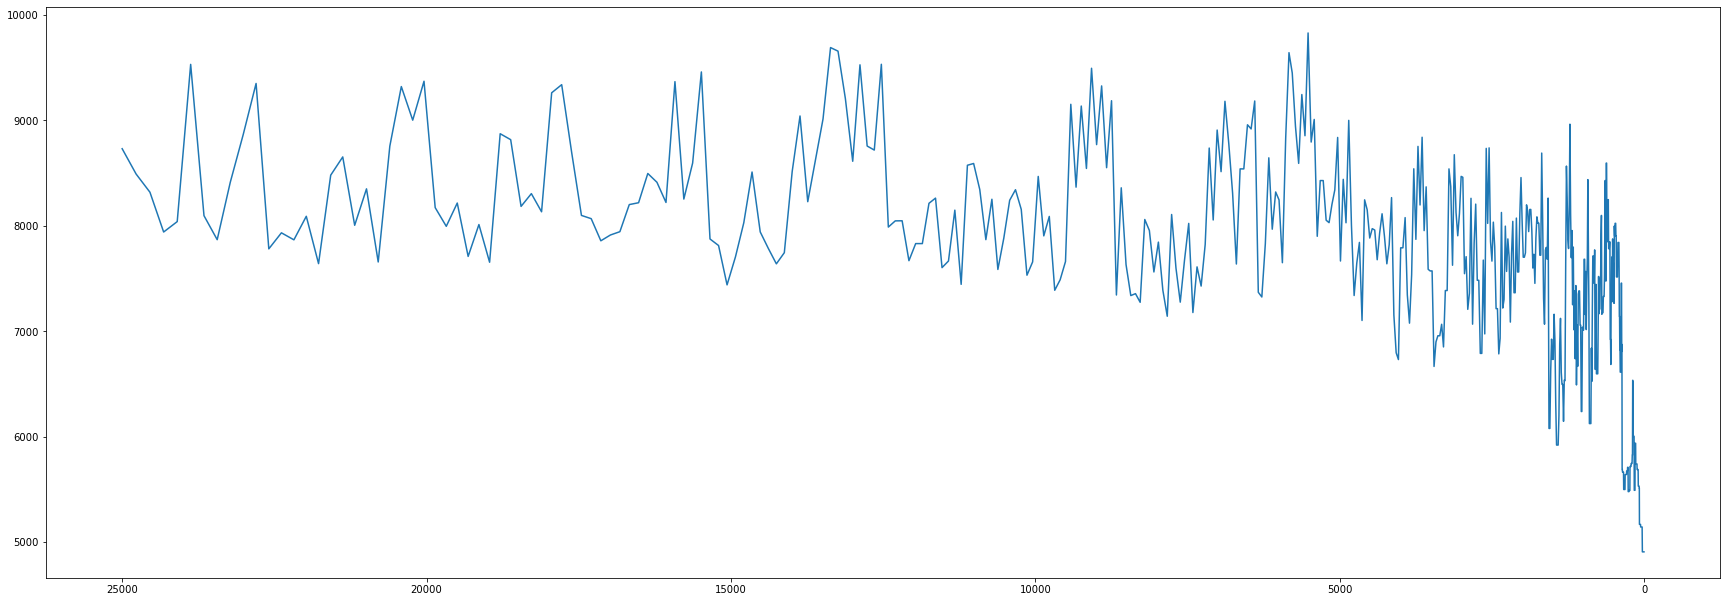

In [8]:
# Run of the second version of the implementation
tsp = TransportOptimizationWithSwaps(pick_routes_for_cars(randomized_cities))
tsp.updates = 1000
tsp.steps= 1000
a, b = tsp.anneal()
print("Distance: ", b)
    
E, T = tsp.getData()
plt.plot(T, E)
ax = plt.gca()
ax.invert_xaxis()
plt.gcf().set_size_inches(30, 10.5)
plt.show()

Distance:  4556.2721611509805


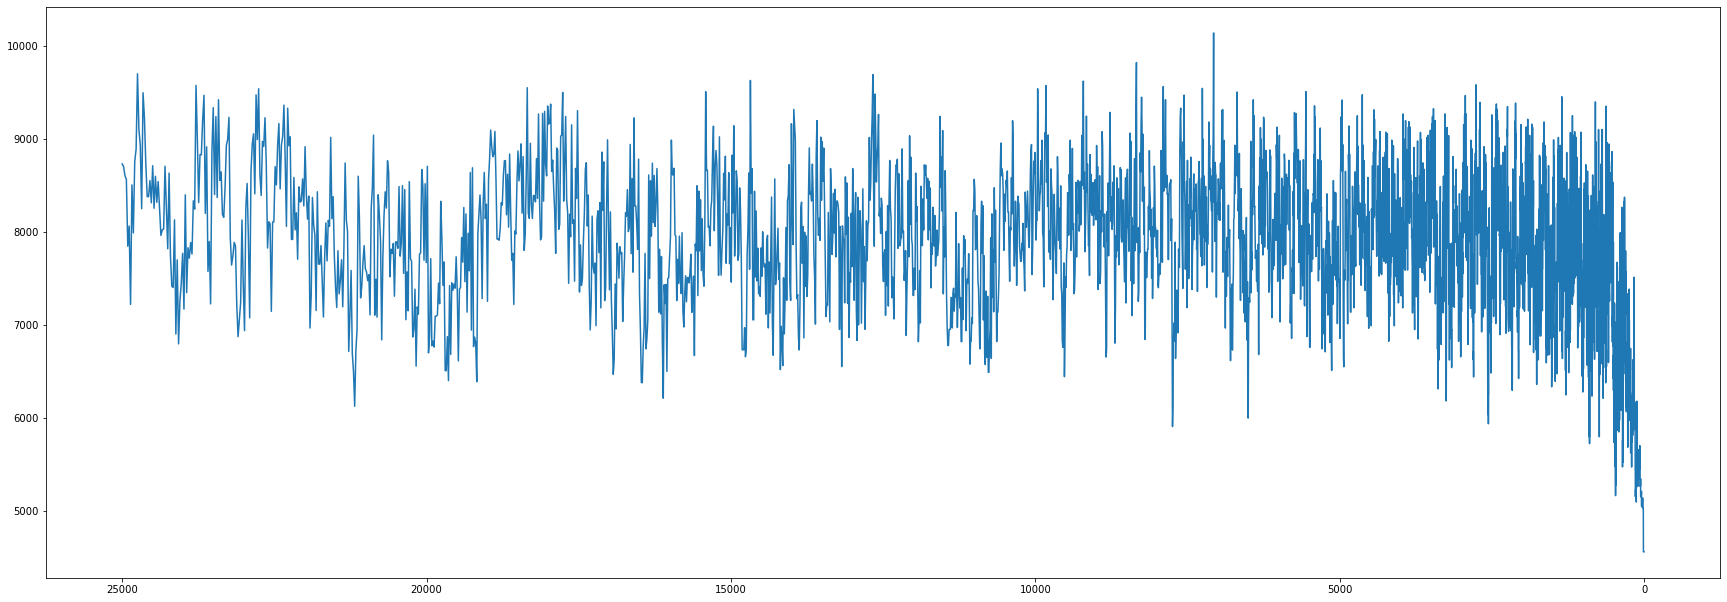

In [9]:
# Run of the second version of the implementation
tsp = TransportOptimizationWithSwaps(pick_routes_for_cars(randomized_cities))
tsp.updates = 10000
tsp.steps= 10000
a, b = tsp.anneal()
total_sum = 0

print("Distance: ", b)
E, T = tsp.getData()
plt.plot(T, E)
ax = plt.gca()
ax.invert_xaxis()
plt.gcf().set_size_inches(30, 10.5)
plt.show()